In [1]:
import wandb
import torch
import sklearn
import numpy as np
import pandas as pd
import logging
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from simpletransformers.classification import MultiLabelClassificationModel, MultiLabelClassificationArgs

In [2]:
# see GPU avaialability
cuda_available = torch.cuda.is_available()

% PER CLASS:

 SDG1      5.354267
SDG2      5.152979
SDG3      7.447665
SDG4      4.388084
SDG5      4.186795
SDG6      5.314010
SDG7      5.756844
SDG8      6.400966
SDG9      5.636071
SDG10     5.152979
SDG11     5.354267
SDG12     5.112721
SDG13    10.265700
SDG14     4.830918
SDG15     5.676329
SDG16     4.951691
SDG17     9.017713
dtype: float64


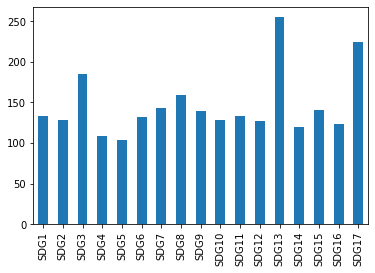

In [3]:
# import data
data = pd.read_csv('OneHot_Combined_cln_utf8.tsv', sep='\t')
data = data.iloc[-1000:,:]
# reformat data
sdg_lst = ['SDG1','SDG2','SDG3','SDG4','SDG5','SDG6','SDG7','SDG8','SDG9','SDG10','SDG11','SDG12','SDG13','SDG14','SDG15','SDG16','SDG17']
data['y'] = data[sdg_lst].values.tolist()
y = data['y']
X = data['abstract']

# plot ratio of data
class_weight = (data[sdg_lst].sum()/ data[sdg_lst].sum().sum())
print('% PER CLASS:\n\n', class_weight*100)
data[sdg_lst].sum().plot.bar()

# split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# add data to dataframes
train_df = pd.DataFrame()
train_df['text'] = X_train
train_df['labels'] = y_train
train_df.reset_index(inplace=True, drop=True)

eval_df = pd.DataFrame()
eval_df['text'] = X_val
eval_df['labels'] = y_val
eval_df.reset_index(inplace=True, drop=True)

# get number of classes
label_count = len(sdg_lst)

In [4]:
# parameter optimisation
sweep_config = {
    "method": "bayes",  # bayes, grid, random
    "metric": {"name": "accuracy", "goal": "maximize"},
    "parameters": {
        "num_train_epochs": {"min": 1, "max": 10},
        "learning_rate": {"min": 5e-5, "max": 4e-4},
        "train_batch_size":{"min": 5, "max": 15},
        "eval_batch_size":{"min": 5, "max": 15},
        "warmup_steps":{"min": 50, "max": 500},
        "weight_decay":{"min": 0.01, "max": 0.1},
        "logging_steps":{"values": [2, 5, 10]},
    },
}

sweep_id = wandb.sweep(sweep_config, entity='sasdghub', project="sasdghub_ml_classify")

# logging
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

Create sweep with ID: ls3h84ec
Sweep URL: https://wandb.ai/sasdghub/sasdghub_ml_classify/sweeps/ls3h84ec


In [5]:
def acc_result(true, pred):
    true=np.argmax(true, axis=1)
    pred=np.argmax(pred, axis=1)
    acc = sklearn.metrics.accuracy_score(true, pred)
    return acc

def f1_macro_result(true, pred):
    true=np.argmax(true, axis=1)
    pred=np.argmax(pred, axis=1)
    f1 = sklearn.metrics.f1_score(true, pred, average='macro')
    return f1

def f1_micro_result(true, pred):
    true=np.argmax(true, axis=1)
    pred=np.argmax(pred, axis=1)
    f1 = sklearn.metrics.f1_score(true, pred, average='micro')
    return f1

def cm_result(true, pred):
    true=np.argmax(true, axis=1)
    pred=np.argmax(pred, axis=1)
    cm = wandb.plot.confusion_matrix(probs=None, y_true=true, preds=pred, class_names=sdg_lst) #sklearn.metrics.multilabel_confusion_matrix(true, pred)
    return cm

In [ ]:
# Optional model configuration
model_args = MultiLabelClassificationArgs(fp16= False,
                                          threshold=0.8,
                                          manual_seed = 4,
                                          use_multiprocessing = True,
                                          overwrite_output_dir=True,
                                          evaluate_during_training = True,
                                          # wandb_project = 'sasdghub_ml_classify',
                                          # wandb_kwargs={
                                          #     'entity':'sasdghub'
                                          #              },
                                          # num_train_epochs=1,
                                          # train_batch_size= 16,
                                          # eval_batch_size= 64,
                                          # warmup_steps= 500,
                                          # weight_decay= 0.01,
                                          # logging_steps= 10,
                                          # learning_rate= 5e-5
                                          
                                         )

def train():
    
    # Initialize a new wandb run 
    wandb.init()

    # Create a MultiLabelClassificationModel
    model = MultiLabelClassificationModel(
        "xlnet",
        "xlnet-base-cased",
        num_labels=label_count,
        args=model_args,
        use_cuda=cuda_available,
        pos_weight=list((1/label_count)/class_weight),
        # show_running_loss=True,
        sweep_config=wandb.config,
    )
    
    # Train the model
    model.train_model(train_df,
                      verbose=True,
                      eval_df=eval_df,
                      accuracy=acc_result,
                      f1_macro=f1_macro_result,
                      f1_micro=f1_micro_result,
                      cm=cm_result)
    
    # Evaluate the model
    result, model_outputs, wrong_predictions = model.eval_model(
        eval_df,
        verbose=True,
        accuracy=acc_result,
        f1_macro=f1_macro_result,
        f1_micro=f1_micro_result,
        cm=cm_result
    )
    
    # Sync wandb
    wandb.join()
    
wandb.agent(sweep_id, train)

INFO:wandb.agents.pyagent:Starting sweep agent: entity=None, project=None, count=None
wandb: Agent Starting Run: s5acot1o with config:
wandb: 	eval_batch_size: 10
wandb: 	learning_rate: 0.0002534101383906862
wandb: 	logging_steps: 10
wandb: 	num_train_epochs: 4
wandb: 	train_batch_size: 9
wandb: 	warmup_steps: 62
wandb: 	weight_decay: 0.04101788217721887
wandb: Currently logged in as: christopher-marais (sasdghub). Use `wandb login --relogin` to force relogin


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForMultiLabelSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForMultiLabelSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'sequence_summary.summary.weight', 'sequence_summary.summary.bias', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream tas

  0%|          | 0/700 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_xlnet_128_0_2
C:\Users\GCM\anaconda3\envs\NLP\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/78 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/300 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_xlnet_128_0_2


Running Epoch 1 of 4:   0%|          | 0/78 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/300 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_xlnet_128_0_2


Running Epoch 2 of 4:   0%|          | 0/78 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/300 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_xlnet_128_0_2


Running Epoch 3 of 4:   0%|          | 0/78 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/300 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_xlnet_128_0_2
INFO:simpletransformers.classification.classification_model: Training of xlnet model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/300 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_xlnet_128_0_2


Running Evaluation:   0%|          | 0/30 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'LRAP': 0.31996736370697526, 'accuracy': 0.05333333333333334, 'f1_macro': 0.005956813104988832, 'f1_micro': 0.053333333333333344, 'cm': <wandb.viz.CustomChart object at 0x000001951B5AF6D0>, 'eval_loss': 0.4266164839267731}


LRAP,▄█▁▇
Training loss,▅▃▂▂▄█▅▄▁▃▆▂▆▄▄▄▆▄▂▃▅▃▃▃▆▃█▆▄▅▃
accuracy,▆█▁▃
eval_loss,█▃▁▁
f1_macro,▇█▁▄
f1_micro,▆█▁▃
global_step,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
lr,▂▃▄▆▇███▇▇▇▇▆▆▆▅▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁
train_loss,▁▃█▄
LRAP,0.31997
Training loss,0.35457


wandb: Agent Starting Run: vqgr2gdb with config:
wandb: 	eval_batch_size: 9
wandb: 	learning_rate: 9.605511004918193e-05
wandb: 	logging_steps: 5
wandb: 	num_train_epochs: 8
wandb: 	train_batch_size: 6
wandb: 	warmup_steps: 220
wandb: 	weight_decay: 0.05513270865152634


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForMultiLabelSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForMultiLabelSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'sequence_summary.summary.weight', 'sequence_summary.summary.bias', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream tas

  0%|          | 0/700 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_xlnet_128_0_2
C:\Users\GCM\anaconda3\envs\NLP\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running Epoch 0 of 8:   0%|          | 0/117 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/300 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_xlnet_128_0_2


Running Epoch 1 of 8:   0%|          | 0/117 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/300 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_xlnet_128_0_2


Running Epoch 2 of 8:   0%|          | 0/117 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/300 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_xlnet_128_0_2


Running Epoch 3 of 8:   0%|          | 0/117 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/300 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_xlnet_128_0_2


Running Epoch 4 of 8:   0%|          | 0/117 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/300 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_xlnet_128_0_2


Running Epoch 5 of 8:   0%|          | 0/117 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/300 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_xlnet_128_0_2


Running Epoch 6 of 8:   0%|          | 0/117 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/300 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_xlnet_128_0_2


Running Epoch 7 of 8:   0%|          | 0/117 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/300 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_xlnet_128_0_2
INFO:simpletransformers.classification.classification_model: Training of xlnet model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/300 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_xlnet_128_0_2


Running Evaluation:   0%|          | 0/34 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'LRAP': 0.8616693833306083, 'accuracy': 0.5966666666666667, 'f1_macro': 0.5873016674220033, 'f1_micro': 0.5966666666666667, 'cm': <wandb.viz.CustomChart object at 0x0000019501102D00>, 'eval_loss': 0.2468522847904002}


LRAP,▁▆▇█████
Training loss,▇▆█▇▅▄▄▄▃▄▄▄▂▂▃▃▃▆▂▂▁▂▃▁▂▂▃▄▂▂▁▂▂▂▂▃▂▂▁▂
accuracy,▁▅▇█████
eval_loss,█▇▃▂▂▁▁▁
f1_macro,▁▅▇█████
f1_micro,▁▅▇█████
global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr,▁▂▃▄▄▅▆▆▇███▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▁▁▁
train_loss,█▆▅▅▁▄▂▄
LRAP,0.86167
Training loss,0.08292


wandb: Agent Starting Run: efkjxfhq with config:
wandb: 	eval_batch_size: 9
wandb: 	learning_rate: 0.00010024715927342804
wandb: 	logging_steps: 10
wandb: 	num_train_epochs: 5
wandb: 	train_batch_size: 12
wandb: 	warmup_steps: 69
wandb: 	weight_decay: 0.07767205879202534


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForMultiLabelSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForMultiLabelSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'sequence_summary.summary.weight', 'sequence_summary.summary.bias', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream tas

  0%|          | 0/700 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_xlnet_128_0_2
C:\Users\GCM\anaconda3\envs\NLP\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/59 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/300 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_xlnet_128_0_2


Running Epoch 1 of 5:   0%|          | 0/59 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/300 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_xlnet_128_0_2


Running Epoch 2 of 5:   0%|          | 0/59 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/300 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_xlnet_128_0_2


Running Epoch 3 of 5:   0%|          | 0/59 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/300 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_xlnet_128_0_2


Running Epoch 4 of 5:   0%|          | 0/59 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/300 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_xlnet_128_0_2
INFO:simpletransformers.classification.classification_model: Training of xlnet model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/300 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_xlnet_128_0_2


Running Evaluation:   0%|          | 0/34 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'LRAP': 0.8715761811169462, 'accuracy': 0.62, 'f1_macro': 0.6133193535565595, 'f1_micro': 0.62, 'cm': <wandb.viz.CustomChart object at 0x00000195011026D0>, 'eval_loss': 0.23734166407409837}


LRAP,▁▆███
Training loss,▇▅▄█▄▅▄▅▃▆▅▄▄▂▁▃▃▂▁▃▅▁▂▂▂▁▁▁▁
accuracy,▁▆███
eval_loss,█▆▃▁▁
f1_macro,▁▅███
f1_micro,▁▆███
global_step,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
lr,▂▃▄▅▆▇██▇▇▇▆▆▆▅▅▅▅▄▄▄▃▃▃▂▂▂▁▁
train_loss,█▇▅▃▁
LRAP,0.87158
Training loss,0.1151


wandb: Agent Starting Run: lli8o0gm with config:
wandb: 	eval_batch_size: 10
wandb: 	learning_rate: 0.00012135978169146152
wandb: 	logging_steps: 5
wandb: 	num_train_epochs: 10
wandb: 	train_batch_size: 5
wandb: 	warmup_steps: 295
wandb: 	weight_decay: 0.054600151481128165


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForMultiLabelSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForMultiLabelSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'sequence_summary.summary.weight', 'sequence_summary.summary.bias', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream tas

  0%|          | 0/700 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_xlnet_128_0_2
C:\Users\GCM\anaconda3\envs\NLP\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Running Epoch 0 of 10:   0%|          | 0/140 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/300 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_xlnet_128_0_2


Running Epoch 1 of 10:   0%|          | 0/140 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/300 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_xlnet_128_0_2


In [ ]:
# train with optimal parameters
# # logging
# logging.basicConfig(level=logging.INFO)
# transformers_logger = logging.getLogger("transformers")
# transformers_logger.setLevel(logging.WARNING)

# # Optional model configuration
# model_args = MultiLabelClassificationArgs(fp16= False,
#                                           threshold=0.8,
#                                           manual_seed = 4,
#                                           use_multiprocessing = True,
#                                           overwrite_output_dir=True,
#                                           evaluate_during_training = True,
#                                           wandb_project = 'sasdghub_ml_classify',
#                                           wandb_kwargs={
#                                               'entity':'sasdghub'
#                                                        },
#                                           num_train_epochs=1,
#                                           train_batch_size= 16,
#                                           eval_batch_size= 64,
#                                           warmup_steps= 500,
#                                           weight_decay= 0.01,
#                                           logging_steps= 10,
#                                           learning_rate= 5e-5
                                          
#                                          )

# # Create a MultiLabelClassificationModel
# model = MultiLabelClassificationModel(
#     "xlnet",
#     "xlnet-base-cased",
#     num_labels=label_count,
#     args=model_args,
#     use_cuda=cuda_available,
#     pos_weight=list(1-class_weight),
    # show_running_loss=True,
    # sweep_config=wandb.config,
# )

# # Train the model
# model.train_model(train_df,
#                   verbose=True,
#                   eval_df=eval_df)

# # Evaluate the model
# result, model_outputs, wrong_predictions = model.eval_model(
#     eval_df,
#     verbose=True,
# )

In [ ]:
# Make predictions with the model
# predictions, raw_outputs = model.predict(["sanitation and clean drinking water"])

#######################################################################################


modify so it can digest longer text (split training data into paragraphs that can be digested)

select and save best model
apply new model in apply script

make testing script with ROC curves and confusion matrices (model.eval)

make testing dataset and train real classifier

get model embedding
train classifier for targets
OR
force nodes for each SDG to output only to targets (SDG7 node does not link to target 9.5 but only to 7.x targets.)